<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библитоек-и-модулей" data-toc-modified-id="Импорт-библитоек-и-модулей-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библитоек и модулей</a></span></li><li><span><a href="#Чтение-данных,-ресемплинг" data-toc-modified-id="Чтение-данных,-ресемплинг-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Чтение данных, ресемплинг</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренды,-сезонность-и-остатки" data-toc-modified-id="Тренды,-сезонность-и-остатки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренды, сезонность и остатки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Адекватность-модели" data-toc-modified-id="Адекватность-модели-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Адекватность модели</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Поиск-лучших-параметров-для-нахождения-признаков" data-toc-modified-id="Поиск-лучших-параметров-для-нахождения-признаков-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Поиск лучших параметров для нахождения признаков</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Рандомный-лес" data-toc-modified-id="Рандомный-лес-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Рандомный лес</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План проекта :

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` ( *number of orders*, «число заказов»).

## Подготовка

###  Импорт библитоек и модулей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import math

from scipy import stats as st

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import  make_pipeline
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score,roc_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

### Чтение данных, ресемплинг 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
display(data)
display(data.info())
display(data.describe().T)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


- Сделали ресемплинг данных по часу 
- После ресемплинга имеем 4416 строк
- минимальное количество 0, максимальное количество 462, среднее 84.4, медиана 78

## Анализ

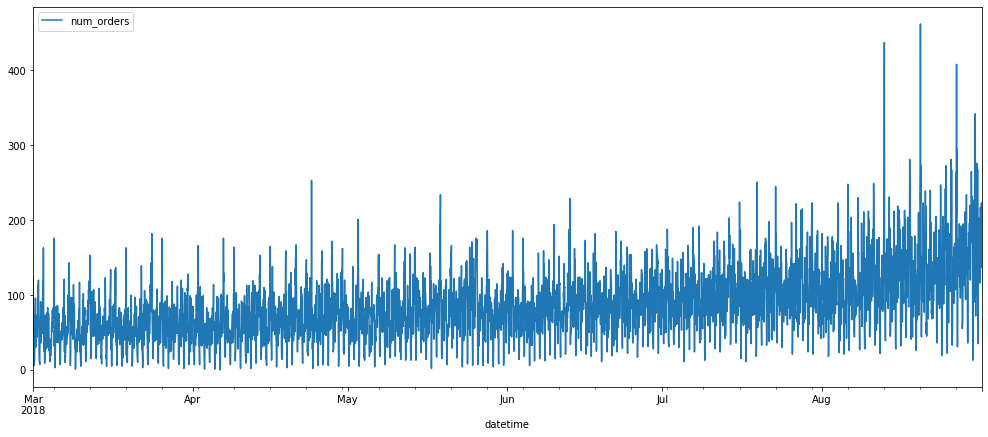

In [3]:
data.plot(figsize=(17,7))

### Тренды, сезонность и остатки

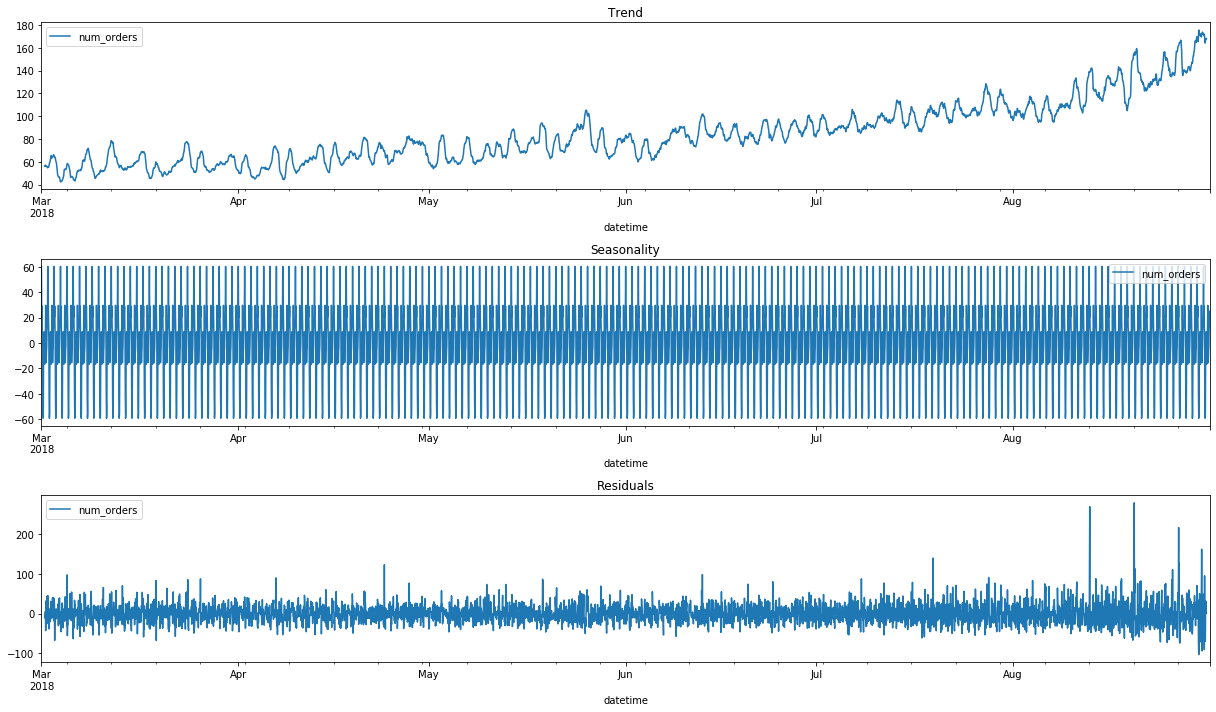

In [4]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(17, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

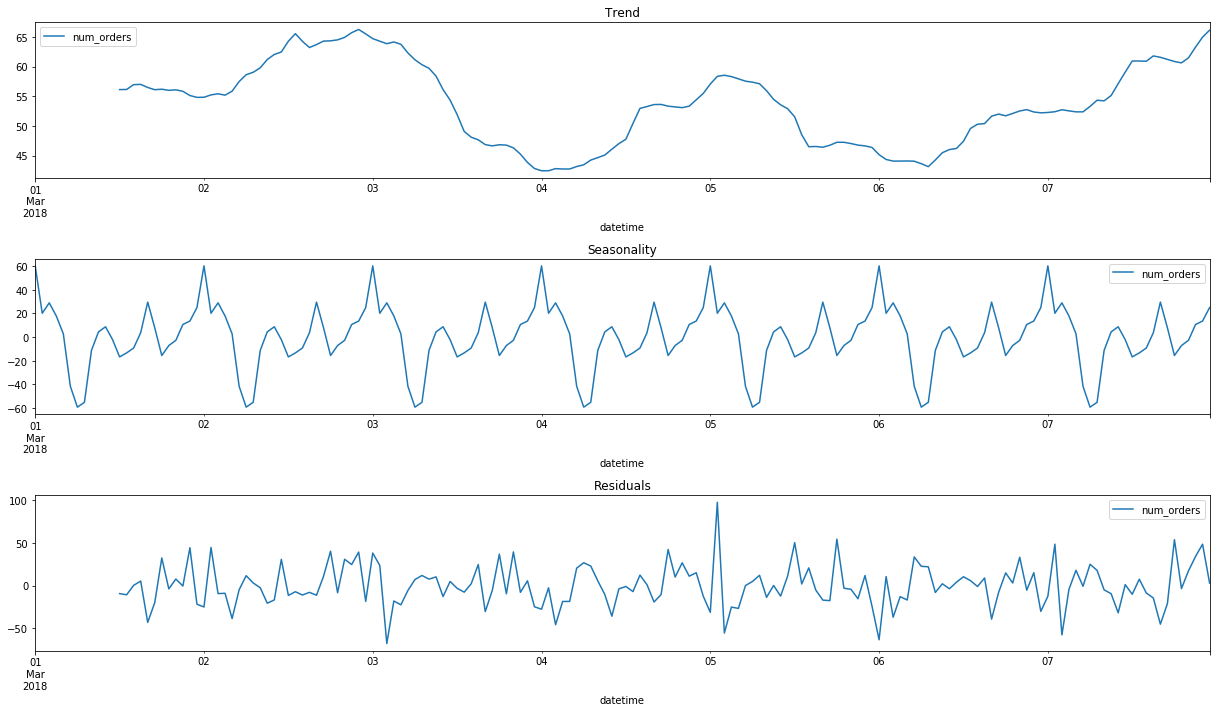

In [5]:
plt.figure(figsize=(17, 10))
plt.subplot(311)
decomposed.trend['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-07'].plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

- можем заметить сезонность в 12:00 


## Обучение

### Адекватность модели

In [6]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [7]:
pred_previous = test.shift()  # предсказания по прогназированию предыдущего значения ряда
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE:",mean_squared_error(test, pred_previous)**0.5)

RMSE: 58.856486242815066


### Создание признаков

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


###  Поиск лучших параметров для нахождения признаков

In [9]:
make_features(data, 99, 72)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)#Обучающая выборка
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)#Тестовая выборка
target_test = test['num_orders']


### Линейная регрессия

In [10]:
model_lr = LinearRegression()

model_lr.fit(features_train, target_train)

predictions_train = model_lr.predict(features_train)
predictions_test = model_lr.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train)**0.5)

RMSE обучающей выборки: 22.1739907397901


### Рандомный лес

In [11]:
clf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
parametrs = { 'n_estimators': range (5, 25, 5),
              'max_depth': range (1,13, 2)}

grid = GridSearchCV(clf, parametrs, cv=tscv, verbose=1,scoring='neg_mean_squared_error',n_jobs=-1)
grid.fit(features_train, target_train)

grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   59.4s finished


{'max_depth': 11, 'n_estimators': 20}

In [12]:
model_rf = RandomForestRegressor(n_estimators = 20, max_depth=11)

model_rf.fit(features_train, target_train)

predictions_train_rf = model_rf.predict(features_train)
predictions_test_rf = model_rf.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train_rf)**0.5)


RMSE обучающей выборки: 11.809637401430713


## Тестирование

In [13]:
print("RMSE линейной регрессии на тестовой выборки: ", mean_squared_error(target_test, predictions_test)**0.5)
print("RMSE рандомного леса на тестовой выборки: ", mean_squared_error(target_test, predictions_test_rf)**0.5)

RMSE линейной регрессии на тестовой выборки:  39.79807878295092
RMSE рандомного леса на тестовой выборки:  40.95404922217058


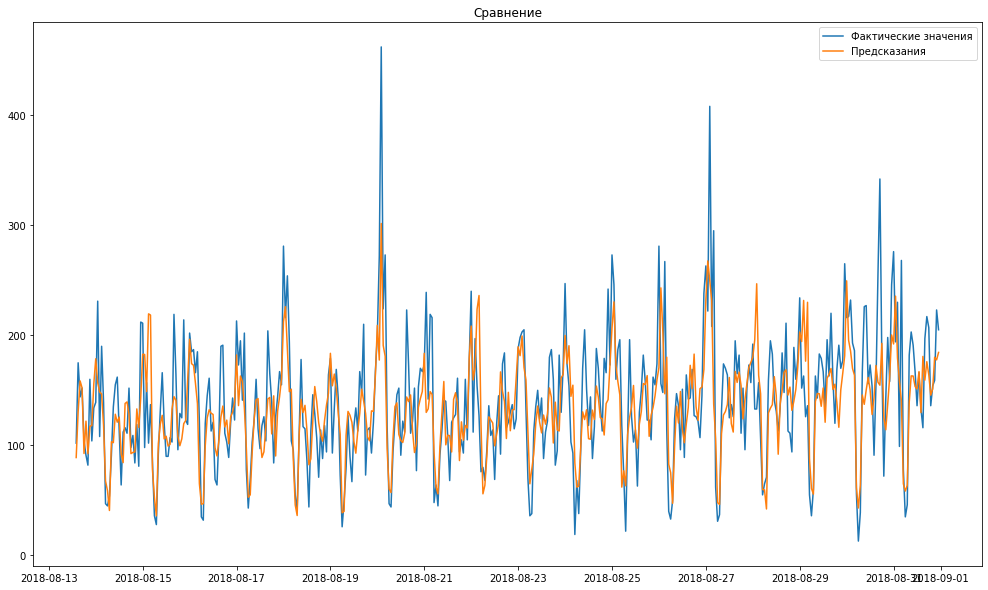

In [14]:
plt.figure(figsize=(17, 10))
plt.title('Сравнение')
plt.plot(features_test.index, target_test, label='Фактические значения')
plt.plot(features_test.index, predictions_test_rf, label='Предсказания')
plt.legend()
plt.show()

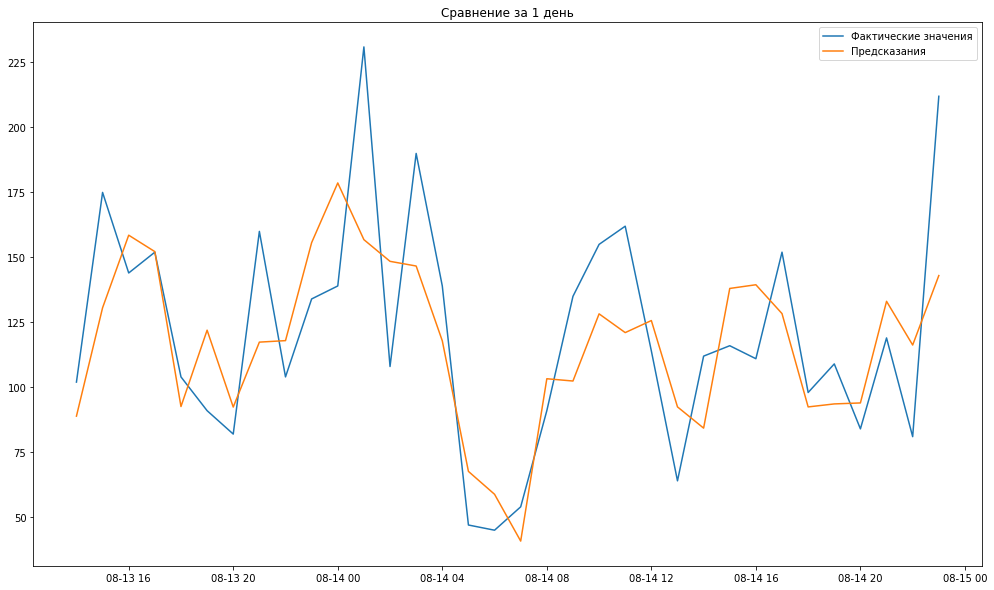

In [15]:
plt.figure(figsize=(17, 10))
plt.title('Сравнение за 1 день')
plt.plot(features_test['2018-08-13':'2018-08-14'].index, target_test['2018-08-13':'2018-08-14'], label='Фактические значения')
plt.plot(features_test['2018-08-13':'2018-08-14'].index, predictions_test_rf[0:34], label='Предсказания')
plt.legend()
plt.show()

## Выводы

- Значение метрики RMSE на двух моделях на тестовых данных меньше чем 48(заданное)
- На обучающих данных Рандомный лес выигрывает у Линейной регрессии